In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1 - Pre-Processing of the raw csv data

### 1.1 Loading the dataset

In [2]:
# The station is Latalaudiere 29439
folder = "29439_O3_2021.csv"
o3_rawdf = pd.read_csv(folder, delimiter=';', decimal=',')
o3_rawdf.head()

,id_site,site,pol,pol_id,date,value,state,rawValue,rawState,unite
0,29439,LATALAUDIERE,O3,8,2021-01-01T00:15:00Z,52.2,A,52.200001,A,microg/m3
1,29439,LATALAUDIERE,O3,8,2021-01-01T00:30:00Z,53.8,A,53.799999,A,microg/m3
2,29439,LATALAUDIERE,O3,8,2021-01-01T00:45:00Z,52.3,A,52.299999,A,microg/m3
3,29439,LATALAUDIERE,O3,8,2021-01-01T01:00:00Z,16.4,Z,16.4,Z,microg/m3
4,29439,LATALAUDIERE,O3,8,2021-01-01T01:15:00Z,471.7,C,471.700012,C,microg/m3


### 1.2 Data exploration and processing

We see that there is a clear undersampling all the class except A. Reminder, the class A means validated data and the class I means unvalidated data. 

In [3]:
o3_rawdf.groupby("state")["id_site"].count()

state
A    30398
C      131
D       80
I       43
M       50
N      248
P     3425
R        9
W      525
Z      131
Name: id_site, dtype: int64

In [4]:
def remove_na_in_rawValue(df, subset):
    return df.dropna(subset=subset)

def process_state(df, state_to_index, state_to_keep=None):
    """
    Process the state by keeping only the desired one and transforming the remaining into categories
    for the model to train on them later on.
    """
    dfcopy = df.copy()
    if state_to_keep:
        dfcopy = dfcopy[dfcopy['state'].isin(state_to_keep)]
    dfcopy['state'] = dfcopy['state'].map(lambda x: state_to_index.get(x, 0))
    return dfcopy


def filter_columns_and_copy(df, columns_to_keep):
    """
    Filters out specified columns from a DataFrame and returns a copy.
    """
    filtered_df = df[columns_to_keep].copy()
    return filtered_df

def convert_object_to_numeric(df, column_to_convert):
    """
    Convert column that are object while they should be numeric
    """
    dfcopy = df.copy()
    for column in column_to_convert:
        dfcopy[column] = pd.to_numeric(dfcopy[column], errors='coerce')
    return dfcopy

def convert_date_to_datetime(df):
    """
    Convert date feature to datetime 
    """
    dfcopy = df.copy()
    dfcopy['datetime'] = pd.to_datetime(dfcopy['date'])
    return dfcopy

def resample_every_hour(df):
    """
    Resample the measures every hour 
    """
    dfcopy = df.copy()
    dfcopy = dfcopy[dfcopy['datetime'].dt.minute == 0]
    return dfcopy

def resample_every_hour_tweaked(df, valid_class_label, invalid_class_label):
    """
    Resample the measures every hour for the valid class while keeping all invalid class data.
    """
    dfcopy = df.copy()
    valid_df = dfcopy[dfcopy['state'] == valid_class_label]
    invalid_df = dfcopy[dfcopy['state'] == invalid_class_label]
    valid_df_resampled = valid_df[valid_df['datetime'].dt.minute == 0]
    resampled_df = pd.concat([valid_df_resampled, invalid_df])
    resampled_df = resampled_df.sort_values(by='datetime')
    return resampled_df

def add_time_features(df):
    """
    Add day of week, hour of day, minute of the hour, month, year, day of month to
    help the model capture the time dependency
    """
    dfcopy = df.copy()
    dfcopy['day_of_week'] = dfcopy['datetime'].dt.dayofweek.astype(int)
    dfcopy['hour_of_day'] = dfcopy['datetime'].dt.hour.astype(int)
    dfcopy['minute_of_hour'] = dfcopy['datetime'].dt.minute.astype(int)
    dfcopy['month_of_year'] = dfcopy['datetime'].dt.month.astype(int)
    dfcopy['year'] = dfcopy['datetime'].dt.year.astype(int)
    dfcopy['day_of_month'] = dfcopy['datetime'].dt.day.astype(int)
    return dfcopy

def add_shifted_target_feature(df, target):
    """
    Add a feature which represents the target feature but shifted 1 time step to the left
    """
    dfcopy = df.copy()
    dfcopy[target + '_shifted'] = dfcopy[target].shift(1)
    return dfcopy


def change_column_order(df, column_order):
    """
    Change column order for better readability
    """
    return df[column_order]

In [5]:
state_to_keep = ['A', 'I']
state_to_index = { 'A' : 1, 'P' : 1, 'O' : 1, 'R' : 1, 'I' : 0 }
target = 'rawValue'

o3_df = remove_na_in_rawValue(o3_rawdf, subset=[target])
o3_df = process_state(o3_df, state_to_index, state_to_keep=state_to_keep)
o3_df = convert_date_to_datetime(o3_df)
# o3_df = resample_every_hour(o3_df) # Uncomment this line if you want to resample every feature to hour stride
o3_df = resample_every_hour_tweaked(o3_df, valid_class_label=state_to_index['A'], invalid_class_label=state_to_index['I'])
o3_df = change_column_order(o3_df, ['id_site', 'site', 'pol', 'pol_id', 'date', 'datetime', 'value', 'state', 'rawValue', 'rawState', 'unite'])
o3_df = add_time_features(o3_df)
o3_df = convert_object_to_numeric(o3_df, ['rawValue', 'value'])

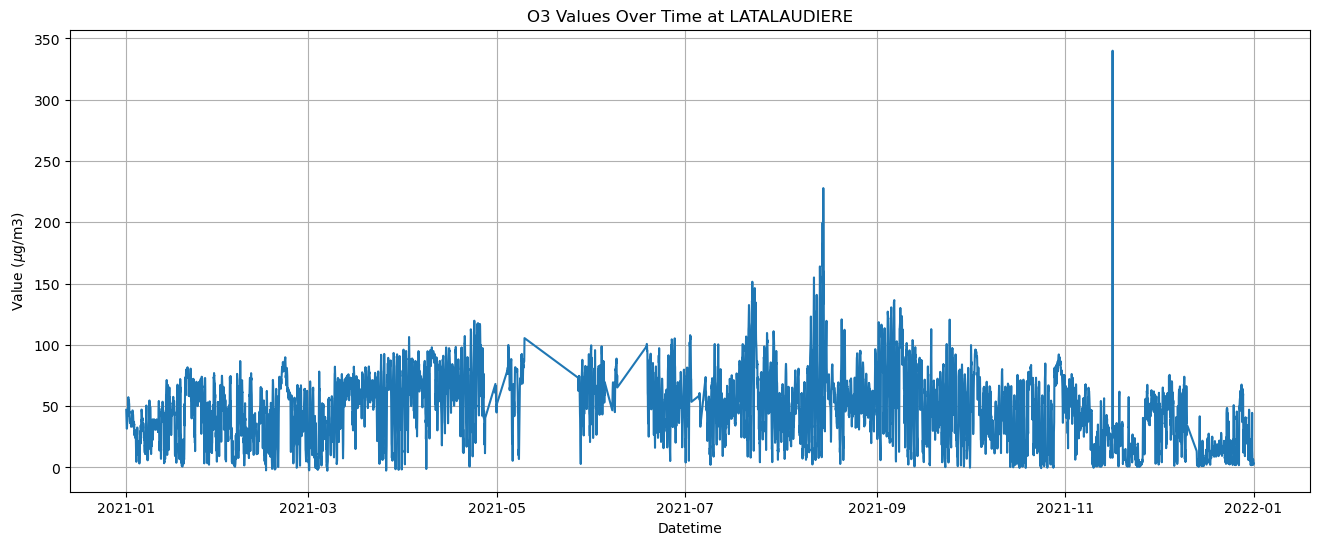

In [6]:
plt.figure(figsize=(16, 6))
plt.plot(o3_df['datetime'], o3_df['rawValue'])
plt.title('O3 Values Over Time at LATALAUDIERE')
plt.xlabel('Datetime')
plt.ylabel(r'Value ($\mu$g/m3)')
plt.grid(True)
plt.show()

### 1.3 Saving the CSV

In [7]:
o3_df.to_csv('29439_O3_2022_processed.csv', index=False)

In [8]:
o3_df.head()

,id_site,site,pol,pol_id,date,datetime,value,state,rawValue,rawState,unite,day_of_week,hour_of_day,minute_of_hour,month_of_year,year,day_of_month
7,29439,LATALAUDIERE,O3,8,2021-01-01T02:00:00Z,2021-01-01 02:00:00+00:00,47.0,1,47.000000,A,microg/m3,4,2,0,1,2021,1
11,29439,LATALAUDIERE,O3,8,2021-01-01T03:00:00Z,2021-01-01 03:00:00+00:00,42.9,1,42.900002,A,microg/m3,4,3,0,1,2021,1
15,29439,LATALAUDIERE,O3,8,2021-01-01T04:00:00Z,2021-01-01 04:00:00+00:00,40.5,1,40.500000,A,microg/m3,4,4,0,1,2021,1
19,29439,LATALAUDIERE,O3,8,2021-01-01T05:00:00Z,2021-01-01 05:00:00+00:00,37.1,1,37.099998,A,microg/m3,4,5,0,1,2021,1
23,29439,LATALAUDIERE,O3,8,2021-01-01T06:00:00Z,2021-01-01 06:00:00+00:00,31.7,1,31.700001,A,microg/m3,4,6,0,1,2021,1


# 2 - Time series analysis

### 2.1 Trend decomposition

We plot the trend of the time series using additive decomposition for different periods of time. 

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

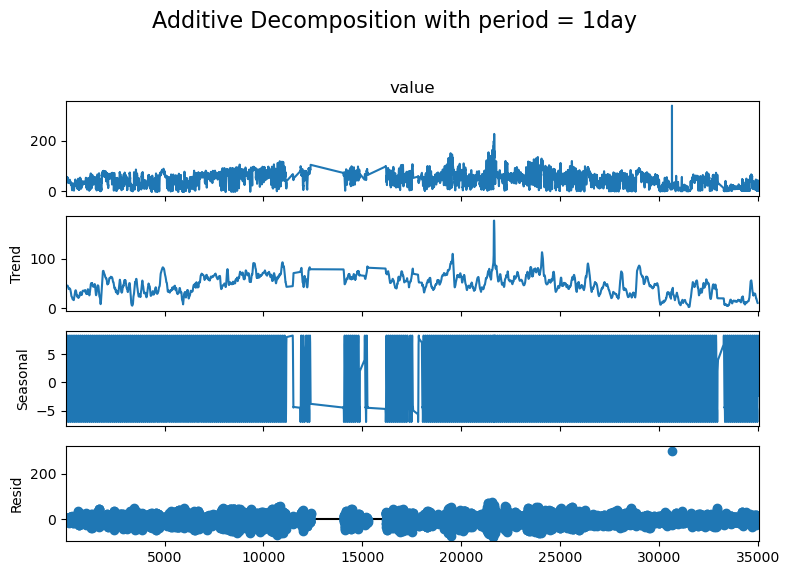

In [10]:
# Additive Decomposition
chosen_period = 24 
additive_decomposition = seasonal_decompose(o3_df['value'], model='additive', period=chosen_period)

# Plot
plt.rcParams.update({'figure.figsize': (8,6)})
additive_decomposition.plot().suptitle('Additive Decomposition with period = 1day', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

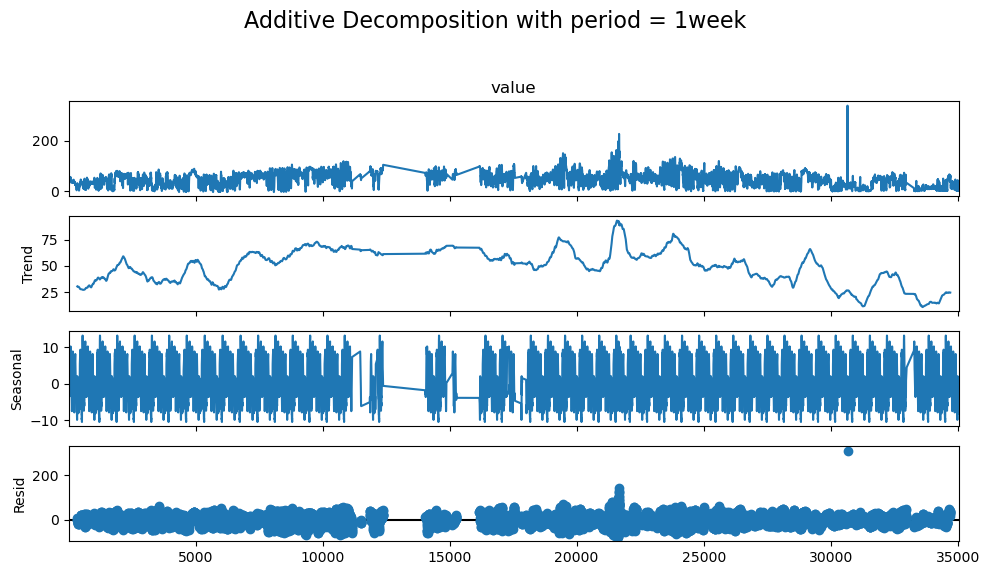

In [11]:
# Additive Decomposition
chosen_period = 24*7 
additive_decomposition = seasonal_decompose(o3_df['value'], model='additive', period=chosen_period)

# Plot
plt.rcParams.update({'figure.figsize': (10,6)})
additive_decomposition.plot().suptitle('Additive Decomposition with period = 1week', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

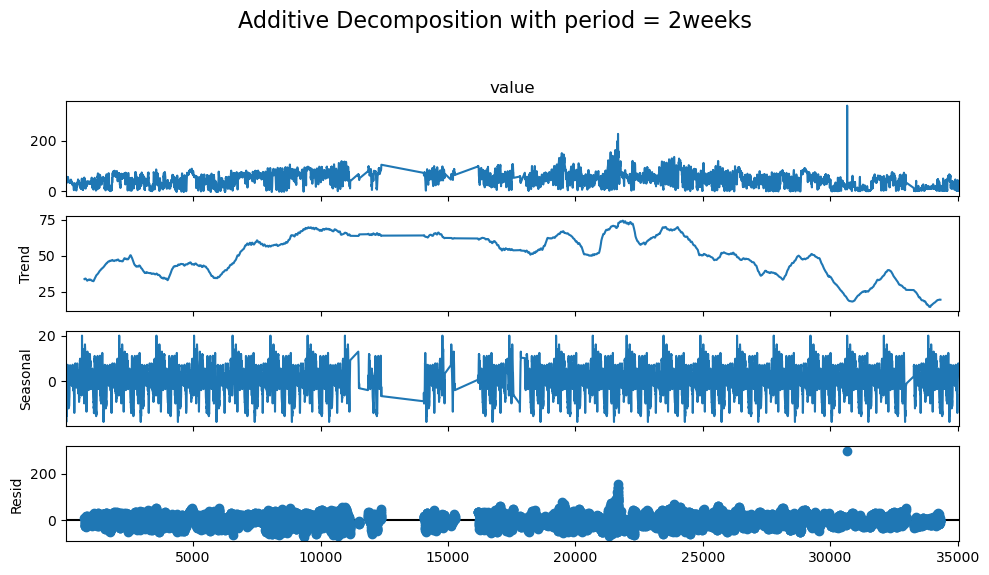

In [12]:
# Additive Decomposition
chosen_period = 24*15
additive_decomposition = seasonal_decompose(o3_df['value'], model='additive', period=chosen_period)

# Plot
plt.rcParams.update({'figure.figsize': (10,6)})
additive_decomposition.plot().suptitle('Additive Decomposition with period = 2weeks', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

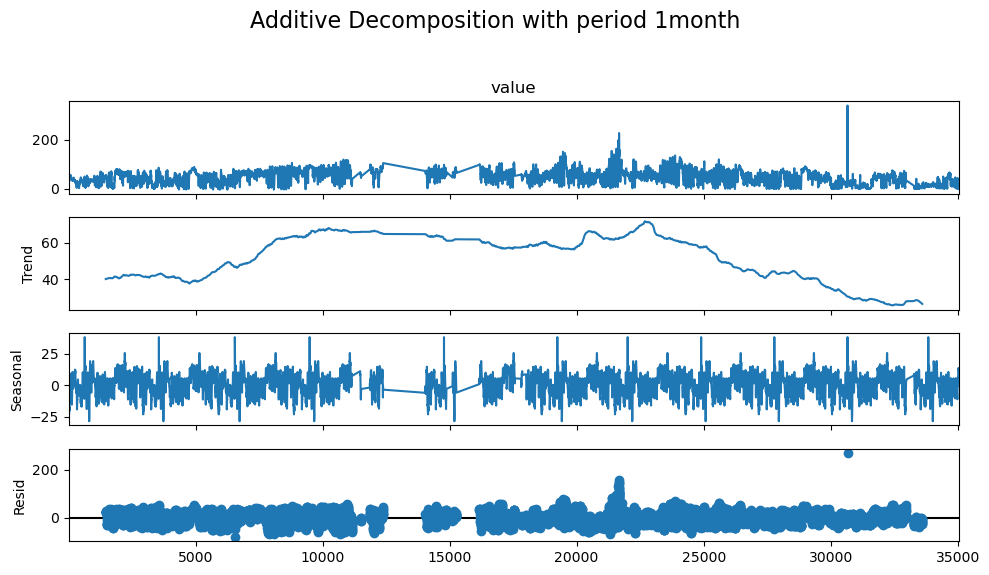

In [13]:
# Additive Decomposition
chosen_period = 24*30
additive_decomposition = seasonal_decompose(o3_df['value'], model='additive', period=chosen_period)

# Plot
plt.rcParams.update({'figure.figsize': (10,6)})
additive_decomposition.plot().suptitle('Additive Decomposition with period 1month', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

### 2.2 Autocorrelation of the time series

Checking for autocorrelations, we get a positive correlation with the first 500-700 lags. 

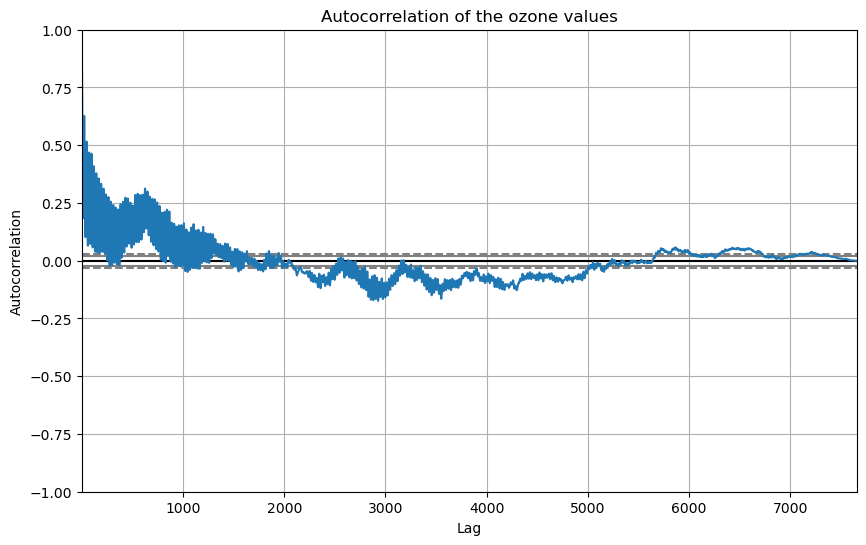

In [14]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(o3_df['value'])
plt.title('Autocorrelation of the ozone values')
plt.show()

### 2.3 Training an ARIMA model to forecast new values of the time series

We will build an ARIMA model trained on the time-series to forecast it. We will employ the ARIMA(x, y, 0) configuration where x is the number of lgs for autoregression and y is the order differencing. 

In [17]:
# Chosing a training set and a testing set 
train_data = o3_df[-24*31:-24*2]
test_data = o3_df[-24*2:]

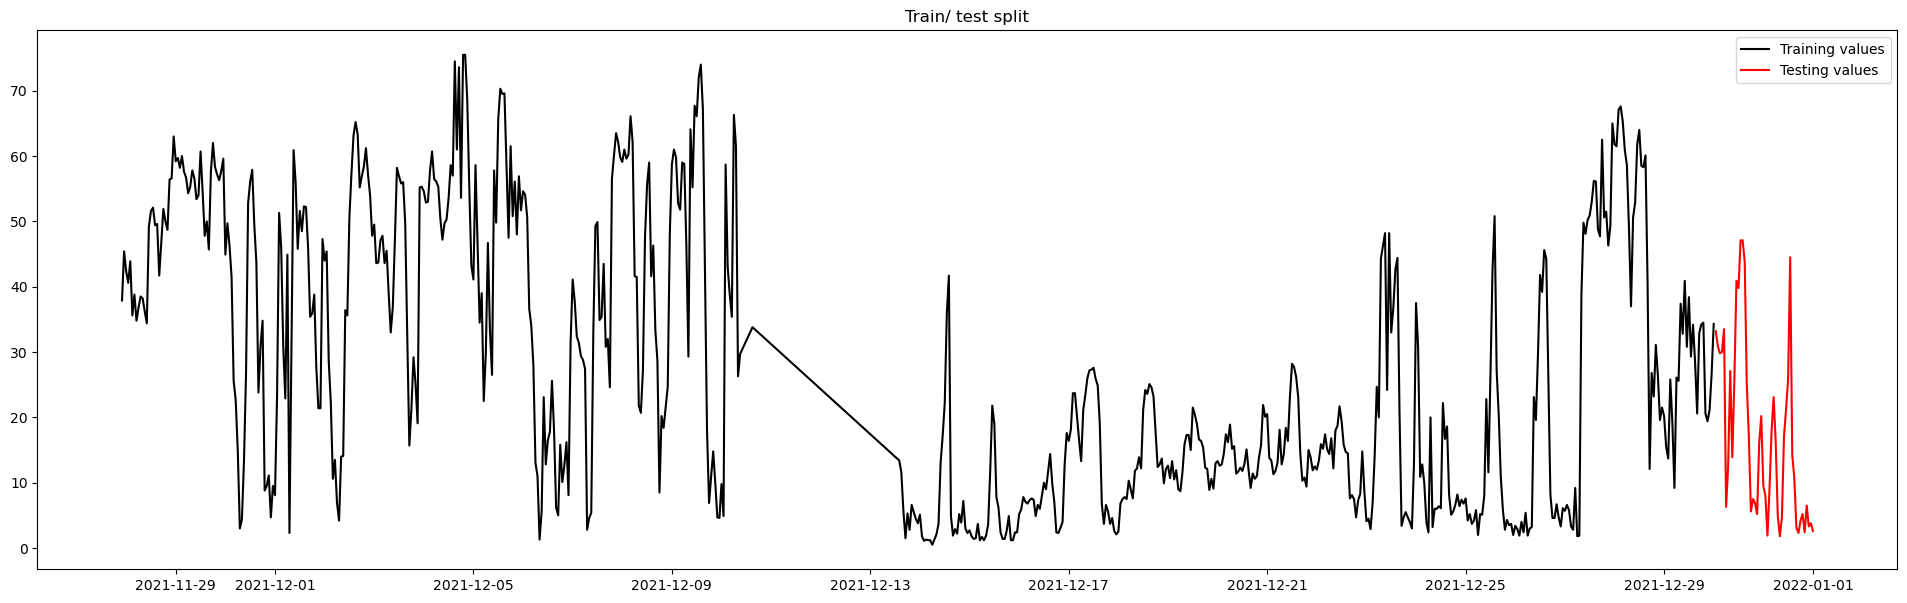

In [18]:
# Plotting the training and testing sets 
plt.figure(figsize=(24,7))
plt.plot(train_data['datetime'],train_data['value'], color = "black", label='Training values')
plt.plot(test_data['datetime'], test_data['value'], color = "red", label='Testing values')
plt.legend()
plt.title('Train/ test split')
plt.show()

In [55]:
# Using auto arima to get the optimal parameters
from pmdarima.arima import auto_arima
model = auto_arima(train_data['value'], trace=True, information_criterion='bic', error_action='ignore', suppress_warnings=True, max_D=10, max_P=10, max_Q=10, max_d=10, max_p=10, max_q=10)
model.fit(train_data['value'])

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=5026.438, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=5042.652, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=5046.752, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=5046.563, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=5036.108, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=5021.799, Time=0.67 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=5015.428, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=5052.134, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : BIC=5052.491, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=5009.053, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : BIC=5040.020, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : BIC=5040.209, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : BIC=5015.413, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

/Users/pierremarie/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/pierremarie/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


/Users/pierremarie/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pierremarie/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pierremarie/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  696
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2494.711
Date:                Sat, 13 Jan 2024   AIC                           4995.421
Time:                        11:15:11   BIC                           5009.053
Sample:                             0   HQIC                          5000.693
                                - 696                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8482      0.026     32.081      0.000       0.796       0.900
ma.L1         -0.9782      0.012    -84.977      0.000      -1.001      -0.956
sigma2        76.6980      2.658     28.860      0.0

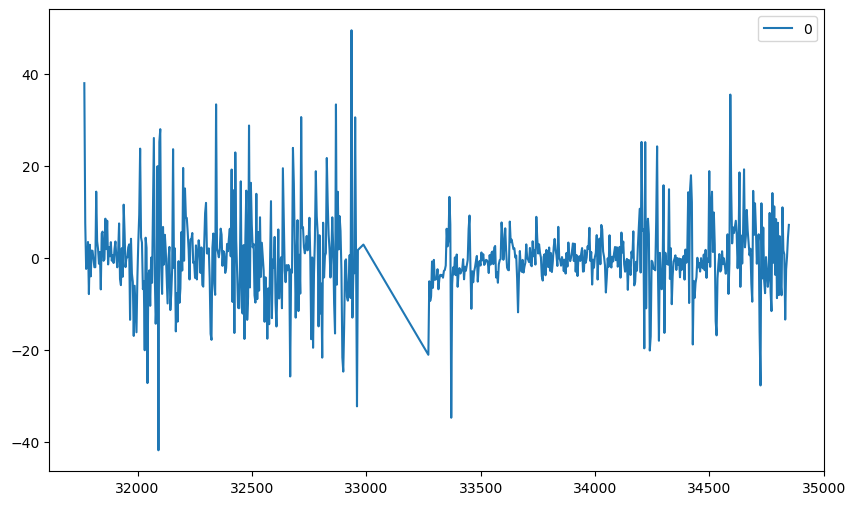

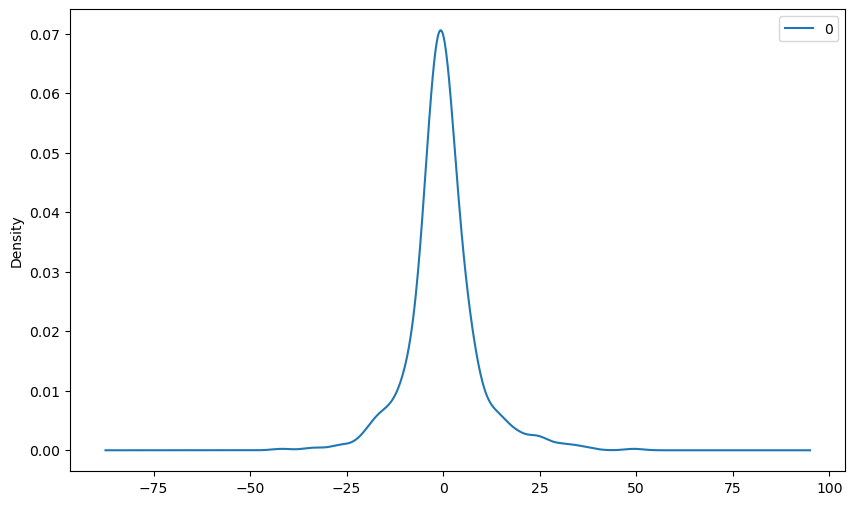

                0
count  696.000000
mean    -0.055918
std      8.877106
min    -41.838012
25%     -3.741609
50%     -0.467509
75%      3.020922
max     49.390427


In [53]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
model = ARIMA(train_data['value'], order=(1,1,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [54]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# making predictions on the value and their confidence bounds using arima(1,1,1)
alpha = .05
history = [x for x in train_data['value']]
predictions = list()
bound_inf = list()
bound_sup = list()

# walk-forward validation
for t in test_data['value']:
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    forecast = model_fit.get_forecast()
    yhat = forecast.predicted_mean
    bound_inf.append(forecast.conf_int(alpha=alpha)[0][0])
    bound_sup.append(forecast.conf_int(alpha=alpha)[0][1])
    predictions.append(yhat)
    obs = t
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=33.782039, expected=33.200000
predicted=32.835634, expected=30.900000
predicted=30.840094, expected=29.800000
predicted=29.883450, expected=30.000000
predicted=30.055712, expected=33.500000
predicted=33.102931, expected=6.300000
predicted=9.418605, expected=12.600000
predicted=14.849558, expected=27.100000
predicted=27.427620, expected=13.900000
predicted=15.946278, expected=25.800000
predicted=26.249245, expected=40.900000
predicted=39.338833, expected=39.800000
predicted=38.419939, expected=47.100000
predicted=44.787925, expected=47.100000
predicted=44.842773, expected=43.800000
predicted=42.028347, expected=25.100000
predicted=25.845004, expected=17.000000
predicted=18.794506, expected=5.600000
predicted=8.829374, expected=7.500000
predicted=10.405577, expected=6.900000
predicted=9.811936, expected=5.200000
predicted=8.257341, expected=16.000000
predicted=17.600896, expected=20.200000
predicted=21.217066, expected=9.500000
predicted=11.893311, expected=8.000000
predicted=1

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

Test RMSE: 9.246


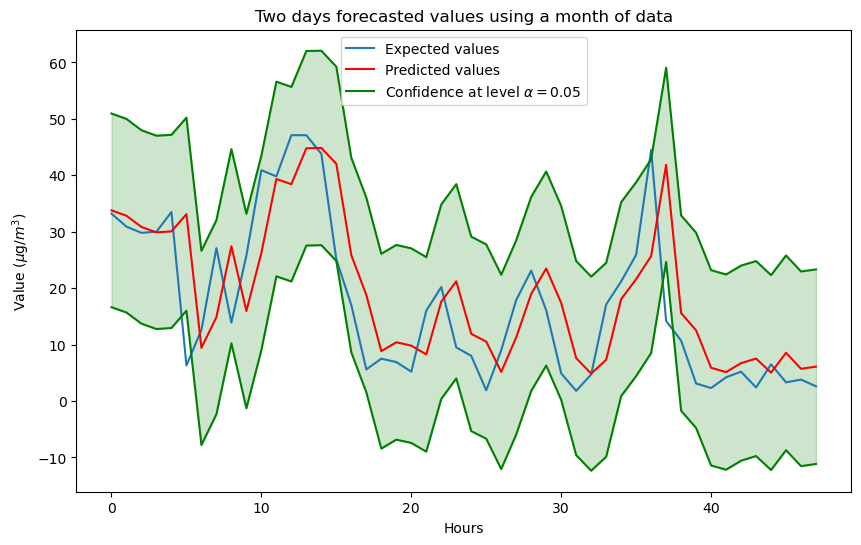

In [52]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test_data['value'], predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.plot(np.arange(0, len(test_data['value'])), test_data['value'], label='Expected values')
plt.plot(np.arange(0, len(test_data['value'])),predictions, color='red', label='Predicted values')

# plot bounds
plt.plot(np.arange(0, len(test_data['value'])), bound_inf, color='green')
plt.plot(np.arange(0, len(test_data['value'])),bound_sup, color='green', label=r'Confidence at level $\alpha =$'+f'{alpha}')
plt.fill_between(np.arange(0, len(test_data['value'])), y1 = bound_inf, y2 = bound_sup, color='green', alpha=.2)
plt.legend()
plt.title('Two days forecasted values using a month of data')
plt.xlabel('Hours')
plt.ylabel(r'Value ($\mu$g/$m^3)$')
plt.show()